In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
epochs = 10000   #10000 
h = 100    #画图网格密度
N = 1000   #内点配置点数
N1 = 100   #边界点配置点数
N2 = 1000  #PDE数据点

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

setup_seed(888888)

In [4]:
def interior(n = N):
    x = torch.rand(n, 1)
    y = torch.rand(n, 1)
    cond = (2 - x **2) * torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [5]:
def down_yy(n = N1):
    #边界 u_yy(x,0)=x^2
    x = torch.rand(n, 1)
    y = torch.zeros_like(x)
    cond = x ** 2
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [6]:
def up_yy(n = N1):
    #边界 u_yy(x,1)=x^2/e
    x = torch.rand(n, 1)
    y = torch.ones_like(x)
    cond = x ** 2 / torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [7]:
def down(n = N1):
    #边界 u(x,0)=x^2
    x = torch.rand(n, 1)
    y = torch.zeros_like(x)
    cond = x ** 2
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [8]:
def up(n = N1):
    #边界 u(x,1)=x^2/e
    x = torch.rand(n, 1)
    y = torch.ones_like(x)
    cond = x ** 2 / torch.e
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [9]:
def left(n = N1):
    #边界 u(0,y)=0
    y = torch.rand(n, 1)
    x = torch.zeros_like(y)
    cond = torch.zeros_like(x)
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [10]:
def right(n = N1):
    #边界 u(1,y)=e^(-y)
    y = torch.rand(n, 1)
    x = torch.ones_like(y)
    cond = torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [11]:
def data_interior(n = N2):
    #PDE内点
    x = torch.rand(n, 1)
    y = torch.rand(n, 1)
    cond = (x ** 2) * torch.exp(-y)
    return x.requires_grad_(True), y.requires_grad_(True), cond

In [12]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2,32),
            torch.nn.Tanh(),
            torch.nn.Linear(32,32),
            torch.nn.Tanh(),
            torch.nn.Linear(32,32),
            torch.nn.Tanh(),   
            torch.nn.Linear(32,32),
            torch.nn.Tanh(),   
            torch.nn.Linear(32,1)                                              
        )
    def forward(self, x):
        return self.net(x)

In [13]:
loss = torch.nn.MSELoss()

In [14]:
def gradients(u, x, order = 1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs = torch.ones_like(u),
                                   create_graph = True,
                                   only_inputs = True, )[0]
    else:
        return gradients(gradients(u, x), x, order = order - 1)

In [15]:
def l_interior(u):
    x, y, cond = interior()
    uxy = u(torch.cat([x,y], dim = 1))
    return loss(gradients(uxy, x, 2) - gradients(uxy, y, 4), cond)

In [16]:
def l_down_yy(u):
    x, y, cond = down_yy()
    uxy = u(torch.cat([x,y], dim = 1))
    return loss(gradients(uxy, y, 2), cond)

In [17]:
def l_up_yy(u):
    x, y, cond = up_yy()
    uxy = u(torch.cat([x,y], dim = 1))
    return loss(gradients(uxy, y, 2), cond)

In [18]:
def l_down(u):
    x, y, cond = down()
    uxy = u(torch.cat([x,y], dim = 1))
    return loss(uxy, cond)    

In [19]:
def l_up(u):
    x, y, cond = up()
    uxy = u(torch.cat([x,y], dim = 1))
    return loss(uxy, cond)    

In [20]:
def l_left(u):
    x, y, cond = left()
    uxy = u(torch.cat([x,y], dim = 1))
    return loss(uxy, cond)  

In [21]:
def l_right(u):
    x, y, cond = right()
    uxy = u(torch.cat([x,y], dim = 1))
    return loss(uxy, cond)  

In [22]:
def l_data(u):
    x, y, cond = data_interior()
    uxy = u(torch.cat([x,y], dim = 1))
    return loss(uxy, cond)     

In [23]:
u = MLP()
opt = torch.optim.Adam(params = u.parameters())

In [24]:
losses = []
for i in range(epochs):
    opt.zero_grad()
    l = l_interior(u) + l_down_yy(u) + l_up_yy(u) + l_down(u) + l_up(u) + l_left(u) + l_right(u)
    l.backward()
    opt.step()
    if i % 200 == 0:
        #print(i)
        print('[%d/%d %d%%] loss: %.10f' % (i, epochs, i / epochs * 100, l.item()))
    losses.append(l.item())
    

[0/10000 0%] loss: 2.3582820892
[200/10000 2%] loss: 0.0975292549
[400/10000 4%] loss: 0.0161382258
[600/10000 6%] loss: 0.0010900605
[800/10000 8%] loss: 0.0003078695
[1000/10000 10%] loss: 0.0002129768
[1200/10000 12%] loss: 0.0001742020
[1400/10000 14%] loss: 0.0001416039
[1600/10000 16%] loss: 0.0008802880
[1800/10000 18%] loss: 0.0001227555
[2000/10000 20%] loss: 0.0001352306
[2200/10000 22%] loss: 0.0002172649
[2400/10000 24%] loss: 0.0001290281
[2600/10000 26%] loss: 0.0001816015
[2800/10000 28%] loss: 0.0002511824
[3000/10000 30%] loss: 0.0000842127
[3200/10000 32%] loss: 0.0001255947
[3400/10000 34%] loss: 0.0000817880
[3600/10000 36%] loss: 0.0001038486
[3800/10000 38%] loss: 0.0000878780
[4000/10000 40%] loss: 0.0000749197
[4200/10000 42%] loss: 0.0000801879
[4400/10000 44%] loss: 0.0010110528
[4600/10000 46%] loss: 0.0001255420
[4800/10000 48%] loss: 0.0000738998
[5000/10000 50%] loss: 0.0000751726
[5200/10000 52%] loss: 0.0005976391
[5400/10000 54%] loss: 0.0001897244
[560

In [25]:
xc = torch.linspace(0, 1, h)
xm, ym = torch.meshgrid(xc, xc)
xx = xm.reshape(-1, 1)
yy = ym.reshape(-1, 1)
xy = torch.cat([xx, yy], dim = 1)
u_pred = u(xy).detach()
u_real = xx * xx *torch.exp(-yy)
u_error = torch.abs(u_pred - u_real)
u_pred_fig = u_pred.reshape(h,h)
u_real_fig = u_real.reshape(h,h)
u_error_fig = u_error.reshape(h,h)
print("Max abs error is:", float(torch.max(torch.abs(u_pred - u_real))))
print(xx)
print(xy)

Max abs error is: 0.01246631145477295
tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])
tensor([[0.0000, 0.0000],
        [0.0000, 0.0101],
        [0.0000, 0.0202],
        ...,
        [1.0000, 0.9798],
        [1.0000, 0.9899],
        [1.0000, 1.0000]])


d:\LYL\Application\Anaconda\Anaconda3\envs\Pytorch\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


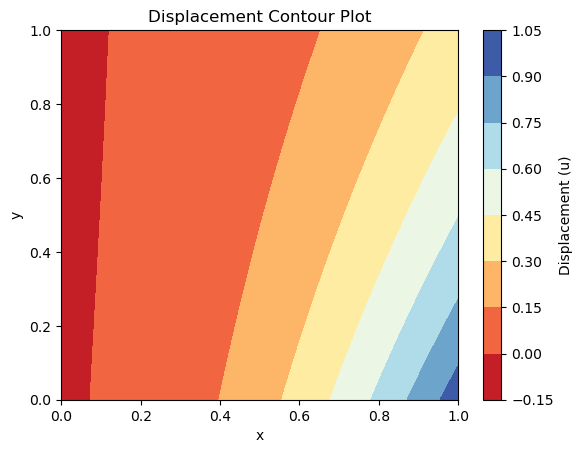

In [26]:
fig = plt.figure(1)
plt.contourf(xm.numpy(), ym.numpy(), u_pred_fig.numpy(), cmap='RdYlBu')
plt.colorbar(label='Displacement (u)')
plt.title('Displacement Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
fig.savefig("PINN solve.png", dpi = 600)

In [27]:
#fig = plt.figure(1)
#plt.scatter(xm.numpy(), ym.numpy(), c=u_pred, alpha=1, edgecolors='none', 
#    cmap='RdYlBu', marker='s', s=15, )
#plt.colorbar(label='Displacement (u)')
#plt.title('Displacement Contour Plot')
#plt.xlabel('x')
#plt.ylabel('y')
#plt.show()
#fig.savefig("PINN solve.png", dpi = 600)

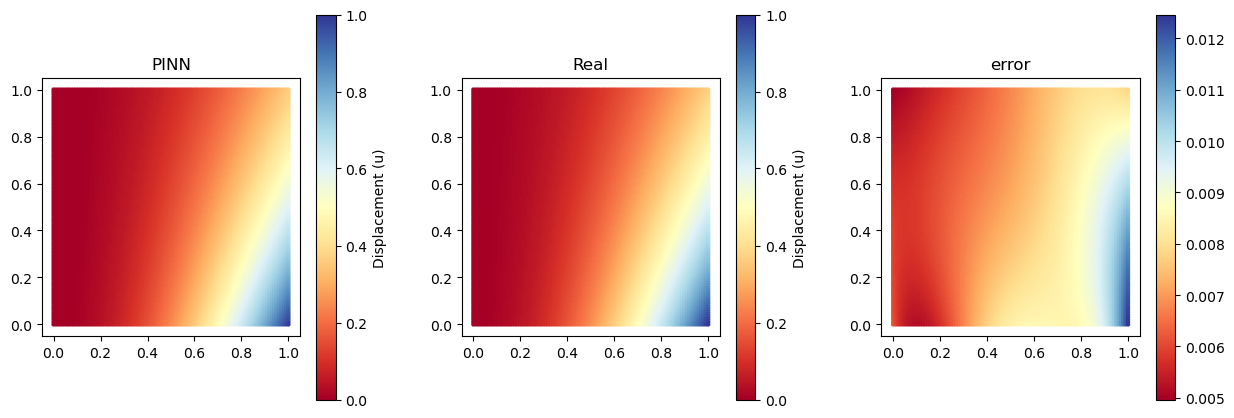

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

vmin, vmax = 0, 1.0

cf = ax[0].scatter(xm.numpy(), ym.numpy(), c=u_pred, alpha=1, edgecolors='none', 
    cmap='RdYlBu', marker='o', s=10, )
cf.set_clim(vmin, vmax)
ax[0].axis('square')
#ax[0].set_xlim([xmin, xmax])
#ax[0].set_ylim([ymin, ymax])
ax[0].set_title('PINN')
fig.colorbar(cf, ax=ax[0], label='Displacement (u)')


cf = ax[1].scatter(xm.numpy(), ym.numpy(), c=u_real, alpha=1, edgecolors='none', 
    cmap='RdYlBu', marker='o', s=10, )
cf.set_clim(vmin, vmax)
ax[1].axis('square')
#ax[1].set_xlim([xmin, xmax])
#ax[1].set_ylim([ymin, ymax])
ax[1].set_title('Real')
fig.colorbar(cf, ax=ax[1], label='Displacement (u)')


cf = ax[2].scatter(xm.numpy(), ym.numpy(), c=u_error, alpha=1, edgecolors='none', 
    cmap='RdYlBu', marker='o', s=10, )
ax[2].axis('square')
#ax[0, 0].set_xlim([xmin, xmax])
#ax[0, 0].set_ylim([ymin, ymax])
ax[2].set_title('error')
fig.colorbar(cf, ax=ax[2])


plt.savefig('u_comparison.png', dpi = 600)

In [29]:
#fig = plt.figure(1)
#ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
#fig.add_axes(ax)
#ax.plot_surface(xm.detach().numpy(), ym.detach().numpy(), u_pred_fig.detach().numpy())
#ax.text2D(0.5, 0.9, "PINN", transform = ax.transAxes)
#plt.show()
#fig.savefig("PINN solve.png")

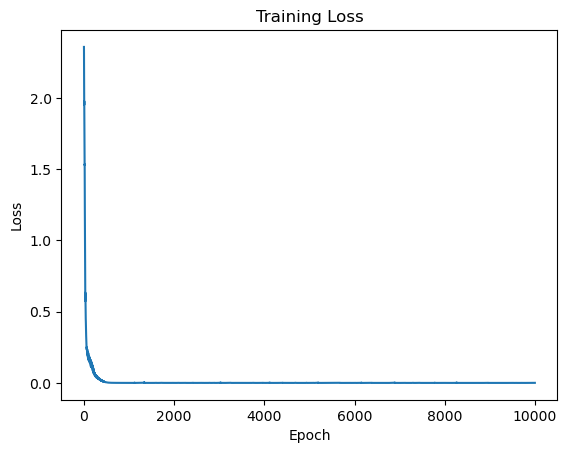

In [30]:
fig = plt.figure(2)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
fig.savefig('Training Loss.png', dpi = 600)
plt.close('all')